#### Wiktor Głazek ####
## BasicTetris - implementacja algorytmu genetycznego w grze typu "tetris" ##

#### Wstęp ####
Celem poniższej pracy było zbadanie skuteczności algorytmu genetycznego do uzyskania jak najlepszej sekwencji ruchów rozgrywanych w przystosowanej do tego autorskiej wersji gry typu Tetris.
Algorytm genetyczny został zaimplementowany w oparciu o bibliotekę pyGAD a sama gra została stworzona w oparciu o kluczowe logiczne podstawy pierwowzoru, wzbogaconego o funkcjonalności służące do oceny wprowadzonych rozwiązań i potrzebne modyfikacje.

#### Implementacja gry Tetris ####
Klasa Block oraz dziedziczące po niej N_kształtne Blocki są reprezentacją brył w Tetrisie(Tetrominoes) w postaci dwuwymiarowych list oraz współrzędnych zerowego pola tej listy. Przestrzeń i mechanika gry zdefiniowana została w klasie BasicTetris, której parametrami są m. in . wysokość i szerokość tworzonej planszy(również jako dwuwymiarowej listy).

Bloki poruszają się po planszy w systemie turowym, zaczynając od pionowego komponentu ruchu o wartości 1 pole(symulowana grawitacja) a następnie o wartość opcjonalnego komponentu poziomego(czyli pojedynczego inputu) w lewo, w prawo lub pozostając w miejscu.

Istnieją podstawowe zasady fizyki: w przypadku napotkania przez blok innego bloku lub podłoża w momencie ruchu pionowego wszelki ruch zostaje przerwany a sam blok staje się permanentnie statyczny;
w razie ruchu poziomego prowadzącego do kolizji z innym blokiem lub ścianą ruch ten zostaje zignorowany a blok nie zmienia pozycji.

Po każdorazowym unieruchomieniu bloku zostają naliczone punkty za położenie wszystkich bloków na planszy. Premiowane jest położenie maksymalnie blisko podłoża oraz zapełnienie pełnej szerokości planszy, skutkujące usunięciem danego rzędu i przesunięciem w dół całej struktury zbudowanej powyżej tego wiersza. Przymusowe przerwanie gry następuje, gdy dowolne pole wiersza o zerowym indeksie przestaje być puste.

In [451]:
from time import sleep
from numpy import std


def split_list(list, chunk_size):
    return [list[i:i + chunk_size] for i in range(0, len(list), chunk_size)]


class Block:

    def __init__(self):
        self.y = 0
        self.x = 0

    def find_extended_fields_right(self):
        extended_fields_right = []
        for row_idx in range(len(self.shape)):
            for field_idx in range(len(self.shape[row_idx])):
                if self.shape[row_idx][field_idx] == self.type:
                    if field_idx == len(self.shape[row_idx]) - 1:
                        extended_fields_right.append((row_idx, field_idx))
                    elif self.shape[row_idx][field_idx + 1] == " ":
                        extended_fields_right.append((row_idx, field_idx))
        return extended_fields_right

    def find_extended_fields_left(self):
        extended_fields_left = []
        for row_idx in range(len(self.shape)):
            for field_idx in range(len(self.shape[row_idx])):
                if self.shape[row_idx][field_idx] == self.type:
                    if field_idx == 0:
                        extended_fields_left.append((row_idx, field_idx))
                    elif self.shape[row_idx][field_idx - 1] == " ":
                        extended_fields_left.append((row_idx, field_idx))
        return extended_fields_left

    def find_extended_fields_down(self):
        extended_fields_down = []
        for row_idx in range(len(self.shape)):
            for field_idx in range(len(self.shape[row_idx])):
                if self.shape[row_idx][field_idx] == self.type:
                    if row_idx == len(self.shape) - 1:
                        extended_fields_down.append((row_idx, field_idx))
                    elif self.shape[row_idx + 1][field_idx] == " ":
                        extended_fields_down.append((row_idx, field_idx))
        return extended_fields_down


class I_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "I"
        self.shape = [["I", "I", "I"]]


class I_Block2(Block):
    def __init__(self):
        super().__init__()
        self.type = "I"
        self.shape = [["I"], ["I"], ["I"]]


class C_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "C"
        self.shape = [["C", "C"],
                      ["C", " "],
                      ["C", "C"],]


class L_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "L"
        self.shape = [[" ", " ", "L"],
                      ["L", "L", "L"]]


class T_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "T"
        self.shape = [["T", "T", "T"],
                      [" ", "T", " "],
                      [" ", "T", " "]]


class U_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "U"
        self.shape = [["U", " ", "U"],
                      ["U", "U", "U"]]


class Y_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "Y"
        self.shape = [["Y", " ", "Y"],
                      ["Y", "Y", "Y"],
                      [" ", "Y", " "]]


class Q_Block(Block):
    def __init__(self):
        super().__init__()
        self.type = "Q"
        self.shape = [["Q", "Q"],
                      ["Q", "Q"]]


class BasicTetris:

    def __init__(self, cols, rows, max_block_moves):
        self.width = cols
        self.height = rows
        self.max_block_moves = max_block_moves
        self.board = [[" " for field_idx in range(
            cols)] for row_idx in range(rows)]
        self.score = 0
        self.cleared_rows = 0

    def print_board(self):
        for row in self.board:
            print(row)
        print("\n")
        
    def insert_block(self, block, y_coord, x_coord):
        for row_idx, row in enumerate(block.shape):
            for field_idx, field in enumerate(row):
                if self.board[row_idx + y_coord][field_idx + x_coord] == " ":
                    self.board[row_idx + y_coord][field_idx + x_coord] = field

    def vertical_shift(self, block):
        for row_idx in range(len(block.shape) - 1, -1, -1):
            for field_idx in range(len(block.shape[row_idx])):
                if self.board[block.y + row_idx][block.x + field_idx] == block.type:
                    self.board[block.y + row_idx +
                               1][block.x + field_idx] = block.type
                    self.board[block.y + row_idx][block.x + field_idx] = " "
        block.y = block.y + 1

    def left_shift(self, block):
        for row_idx in range(len(block.shape)):
            for field_idx in range(len(block.shape[row_idx])):
                if block.shape[row_idx][field_idx] == block.type:
                    self.board[block.y + row_idx][block.x +
                                                  field_idx - 1] = block.type
                    self.board[block.y +
                               row_idx][block.x + field_idx] = " "
        block.x = block.x - 1

    def right_shift(self, block):
        for row_idx in range(len(block.shape)):
            for field_idx in range(len(block.shape[row_idx]) - 1, -1, -1):
                if block.shape[row_idx][field_idx] == block.type:
                    self.board[block.y + row_idx][block.x +
                                                  field_idx + 1] = block.type
                    self.board[block.y + row_idx][block.x + field_idx] = " "
        block.x = block.x + 1

    def check_free_space_below(self, block):
        free_space_below = True
        for (y_coord, x_coord) in block.find_extended_fields_down():
            if not block.y + y_coord + 1 > self.height - 1:
                if not self.board[block.y + y_coord + 1][block.x + x_coord] == " ":
                    free_space_below = False
            else:
                free_space_below = False
        return free_space_below

    def check_free_space_left(self, block):
        free_space_left = True
        for (y_coord, x_coord) in block.find_extended_fields_left():
            if block.x - 1 >= 0:
                if not self.board[block.y + y_coord][block.x + x_coord - 1] == " ":
                    free_space_left = False
            else:
                free_space_left = False
        return free_space_left

    def check_free_space_right(self, block):
        free_space_right = True
        for (y_coord, x_coord) in block.find_extended_fields_right():
            if not block.x + x_coord + 1 > self.width - 1:
                if not self.board[block.y + y_coord][block.x + x_coord + 1] == " ":
                    free_space_right = False
            else:
                free_space_right = False
        return free_space_right

    def move_block(self, block, move):
        if self.check_free_space_below(block):
            self.vertical_shift(block)
            if self.check_free_space_below(block):
                match move:
                    case 0:  # static
                        pass
                    case 1:  # left
                        if self.check_free_space_left(block):
                            self.left_shift(block)
                    case 2:  # right
                        if self.check_free_space_right(block):
                            self.right_shift(block)
                    case _:
                        raise (Exception(f"Move \"{move}\" not recognised"))

    def prepare_game_input(self, blocks_list, solution_list):
        moves_list = split_list(solution_list, self.max_block_moves)
        return [(blocks_list[i], moves_list[i]) for i in range(len(blocks_list))]

    def game_loop(self, blocks_list, solution_list):
        for (block, moves) in self.prepare_game_input(blocks_list, solution_list):
            if self.check_game_over():
                break
            self.insert_block(block, 0, 0)
            for move in moves:
                self.move_block(block, move)
                if self.check_game_over():
                    break
            self.score_game()
        for block in blocks_list:
            block.x = 0
            block.y = 0

    def game_loop_live(self, blocks_list, solution_list):
        for (block, moves) in self.prepare_game_input(blocks_list, solution_list):
            if self.check_game_over():
                break
            self.insert_block(block, 0, 0)
            self.print_board()
            sleep(0.03)
            move_num = 0
            for move in moves:
                move_num += 1
                # print("step:", move_num, "score", self.score)
                self.move_block(block, move)
                self.print_board()
                sleep(0.03)
                if self.check_game_over():
                    break
            self.score_game()
        for block in blocks_list:
            block.x = 0
            block.y = 0
            print("Final score:", self.score, "Cleared rows:", self.cleared_rows)

    def check_game_over(self):
        if not all([True if field == " " else False for field in self.board[0]]):
            return True

    def clear_row(self, row_idx):
        self.board.pop(row_idx)
        self.board.insert(0, [" " for i in range(self.width)])

    def score_game(self):
        for row_idx in range(len(self.board)-1, -1, -1):  # add score for each block
            self.score += sum([pow(row_idx, 2) if field !=
                              " " else 0 for field in self.board[row_idx]])
        for row_idx in range(len(self.board)-1, -1, -1):  # bous score for full row
            if all([True if field != " " else False for field in self.board[row_idx]]):
                self.score += 10000
                self.cleared_rows += 1
                self.clear_row(row_idx)

    def find_gaps(self):
        gap_count = 0
        board_copy = self.board.copy()
        while True:
            init_gap_count = gap_count
            for row_idx in range(len(self.board)-1, -1, -1):
                for field_idx in range(self.width):
                    if row_idx - 1 >= 0:
                        if board_copy[row_idx][field_idx] == " " and board_copy[row_idx - 1][field_idx] != " ":
                            board_copy[row_idx][field_idx] = "*"
                            gap_count += 1
            if gap_count == init_gap_count:
                # for row in board_copy:
                #     print(row)
                return gap_count

    def find_peaks(self):
        max_heights = []
        columns_idx = [i for i in range(self.width)]
        board_copy = self.board.copy()
        while True:
            for row_idx in range(len(self.board)):
                for field_idx in columns_idx:
                    if self.board[row_idx][field_idx] != " ":
                        max_heights.append(row_idx)
                        board_copy[row_idx - 1][field_idx] = "↑"
                        columns_idx = [
                            col for col in columns_idx if col != field_idx]
                    elif row_idx == self.height - 1:
                        columns_idx = [
                            col for col in columns_idx if col != field_idx]
                if len(columns_idx) == 0:
                    # for row in board_copy:
                    #     print(row)
                    return max_heights

    def print_results(self):
        print("Score:", self.score)
        print("Cleared rows:", self.cleared_rows)

    def analyse_game(self):
        base_mark = self.score
        clear_bonus = self.cleared_rows * 10000
        gap_penalty = self.find_gaps() * -200
        height_diff_penalty = std(self.find_peaks()) * -1000
        return base_mark + clear_bonus + gap_penalty + height_diff_penalty


#### Derfinicja problemu ####
Na potrzeby badań, problem zostaje zakodowany przy pomocy następujących zmiennych:
- Wysokość i szerokość planszy gry
- Maksymalna łączna liczba przesunięć poziomych jednego bloku (de facto równa wysokości)
- Przestrzeń genów: przesunięcie o zero, w lewo, w prawo (0, 1, 2)
- Tablica obiektów typu N_kształtny_Block do ułożenia

Chromosom algorytmu genetycznego to tablica genów o długości:

*liczba_wszystkich_bloków * liczba_ruchów_bloku*

#### Przykładowe inputy ####

In [452]:
class Input:
    def __init__(self, blocks_list, width, height):
        self.problem = blocks_list
        self.board_width = width
        self.board_height = height
        self.moves_per_block = height


# small
sm_input_1 = Input([Q_Block(), I_Block2(), I_Block(), Q_Block(),
                    C_Block(), L_Block(), I_Block2(), Q_Block()], 5, 10)

sm_input_2 = Input([L_Block(), Q_Block(), I_Block(), Q_Block(),
                    Q_Block(), U_Block(), I_Block2(), I_Block2()], 5, 10)

sm_input_3 = Input([C_Block(), T_Block(), I_Block(), I_Block2(),
                    Y_Block(), U_Block(), Q_Block(), I_Block2()], 5, 10)

sm_inputs_list = [sm_input_1, sm_input_2, sm_input_3]

# medium
md_input_1 = Input([C_Block(), L_Block(), C_Block(), I_Block(), Q_Block(), I_Block(),
                    T_Block(), U_Block(), L_Block(), I_Block2(), Q_Block(), Q_Block()], 8, 16)

md_input_2 = Input([L_Block(), L_Block(), Q_Block(), C_Block(), Q_Block(), L_Block(),
                    Q_Block(), U_Block(), T_Block(), C_Block(), I_Block2(), L_Block()], 8, 16)

md_input_3 = Input([C_Block(), L_Block(), L_Block(), C_Block(), Q_Block(), C_Block(),
                    C_Block(), T_Block(), I_Block2(), I_Block2(), I_Block(), I_Block2()], 8, 16)

md_inputs_list = [md_input_1, md_input_2, md_input_3]

#large
lg_input_1 = Input([U_Block(), U_Block(), I_Block2(), I_Block(), L_Block(), I_Block(), Y_Block(),
                    I_Block2(), U_Block(), Q_Block(), I_Block2(), Q_Block(), Q_Block(), Y_Block()], 10, 20)

lg_input_2 = Input([U_Block(), C_Block(), Q_Block(), T_Block(), I_Block2(), I_Block(), Y_Block(),
                    Q_Block(), I_Block(), U_Block(), U_Block(), I_Block(), Q_Block(), L_Block()], 10, 20)

lg_input_3 = Input([I_Block2(), I_Block(), I_Block(), Q_Block(), T_Block(), I_Block2(), L_Block(),
                    T_Block(), Y_Block(), U_Block(), Q_Block(), Q_Block(), Q_Block(), U_Block()], 10, 20)

lg_inputs_list = [lg_input_1, lg_input_2, lg_input_3]


#### Funkcja fitness ####
Funkcja fitness inicjuje instancję gry BasicTetris, przeprowadza symulację rozgrywki zgodnie z podanym chromosomem a następnie wywołuje metodę analyse_game() na finalnej postaci planszy gry, która zwraca liczbową wartość z zakresu 0 do kilkuset tysięcy (w zależności od liczby bloków i wielkości planszy, gdzie plansza 10 * 20 jest rozmiarem maksymalnym).

Ze względu na fakt, iż badany problem dotyczy skończonej liczby bloków, zdobyte podczas gry punkty nie są jedyną miarą rozróżniającą słabe i dobre rozwiązanie. Stąd przy liczeniu wartości liczbowej metoda analyse_game() bierze pod uwagę następujące właściwości rozmieszczenia bloków:
- base_mark(+) – Punkty zdobyte w grze za ułożenie bloków
- clear_bonus(+) – Liczba zapełnionych w pełni wierszy podczas gry
- gap_penalty(-) – Liczba wszystkich częściowo lub całkowicie zablokowanych pustych komórek tablicy. Za częściowo zablokowaną uznaje się komórkę, która straciła nieprzerwany pionowy wektor pustych komórek nad sobą.
- height_diff_penalty(-) – odchylenie standardowe indeksów rzędów najwyżej położonych fragmentów bloków dla każdej kolumny. Znaczne rozproszenie bloków skutkuje dużą wartością.

In [463]:
input = lg_input_3
board_width = input.board_width
board_height = input.board_height
moves_per_block = input.moves_per_block
problem = input.problem

def fitness_func(solution, solution_idx):
    tetris_instance = BasicTetris(board_width, board_height, moves_per_block)
    tetris_instance.game_loop(problem, solution)
    fitness = tetris_instance.analyse_game()
    return fitness


#### Algorytm genetyczny ####

In [464]:
import pygad

gene_space = [0, 1, 2]
num_genes = len(problem)*moves_per_block
sol_per_pop = 1000
num_generations = 30
num_parents_mating = 500
keep_parents = 50
mutation_percent_genes = 8
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

solution_ga, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution:")
print([int(num) for num in solution_ga.tolist()])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution:
[0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2]
Fitness value of the best solution = 117035.30615433009


#### Prezentacja najlepszego rozwiązania ####

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', 'U', ' ', 'U', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', 'U', 'U', 'U', ' ', ' ', ' ']
[' ', 'Q', 'Q', ' ', ' ', ' ', 'Y', ' ', 'Y', ' ']
[' ', 'Q', 'Q', ' ', ' ', ' ', 'Y', 'Y', 'Y', ' ']
['U', ' ', 'U', 'Q', 'Q', 'Q', 'Q', 'Y', ' ', 'L']
[' ', 'T', 'T', 'T', ' ', ' ', 'T', 'T', 'T', ' ']
[' ', ' ', 'T', ' ', ' ', ' ', ' ', 'T', ' ', ' ']
['I', 'I', 'T', ' ', ' ', ' ', ' ', 'T', ' ', ' ']
['I', 'I', 'Q', 'Q', ' ', 'I', 'I', 'I', ' ', ' ']
['I', 'I', 'Q', 'Q', ' ', ' ', 

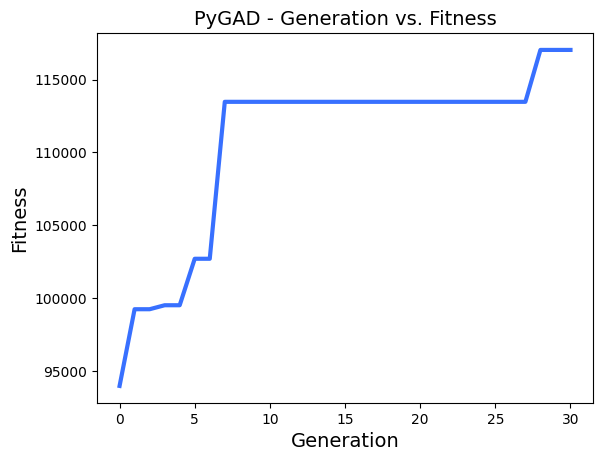

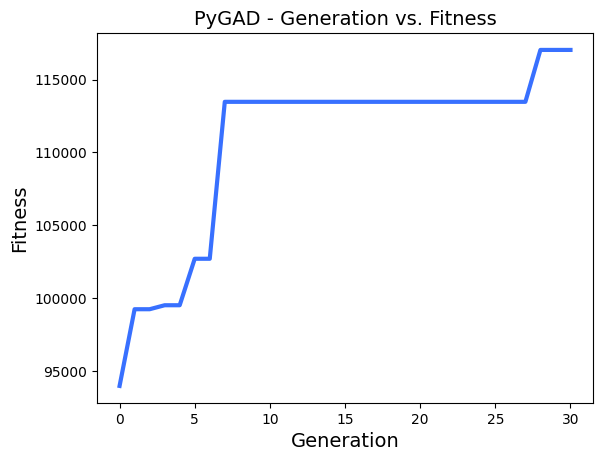

In [465]:
tetris_presentation = BasicTetris(board_width, board_height, moves_per_block)
tetris_presentation.game_loop(problem, [int(num) for num in solution_ga.tolist()])
tetris_presentation.print_board()
tetris_presentation.print_results()
ga_instance.plot_fitness()

#### Pomiary efektywności i czasu ####

Dla kadej pętli wybrano najlepsze wyniki funkcji fitness znajdujące się w 95 kwantylu, zliczono ich liczbę oraz policzono średnią z odpowiadającym im wyników prób czasowych.

##### Small input #####

In [456]:
from time import time
from random import randint
import numpy

sm_fitness_measurements_list = []
sm_fit_time_measurements_list = []

for i in range(100):
    rand_idx = randint(0, 2)
    input = sm_inputs_list[rand_idx]
    num_genes = len(problem)*moves_per_block
    sol_per_pop = 100
    num_generations = 10
    num_parents_mating = 50
    keep_parents = 5
    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes)
    start = time()
    ga_instance.run()
    stop = time()
    _, solution_fitness, _ = ga_instance.best_solution()
    sm_fitness_measurements_list.append(solution_fitness)
    sm_fit_time_measurements_list.append((solution_fitness, stop - start))

5 1.1925715923309326


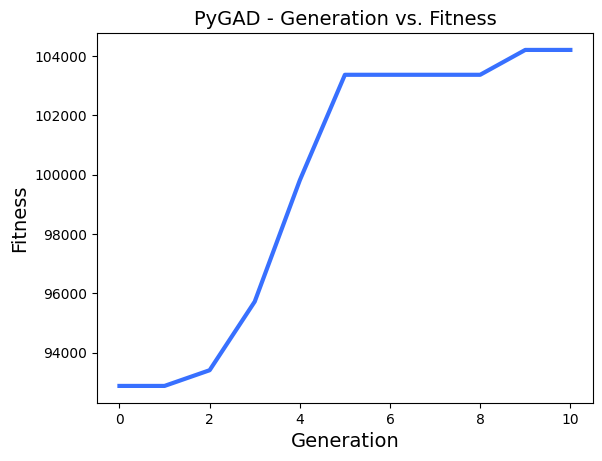

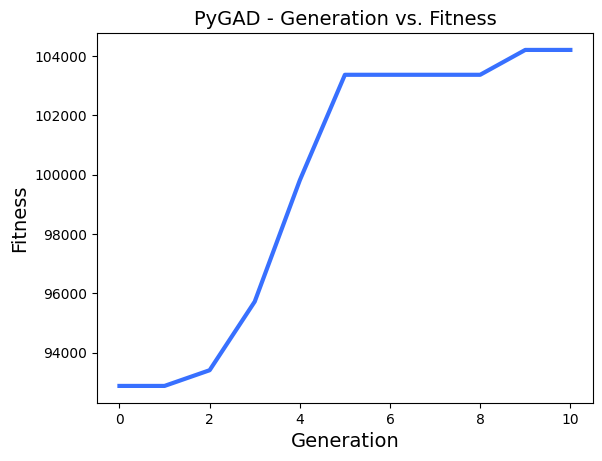

In [457]:
sm_fitness_data_arr = numpy.array(sm_fitness_measurements_list)
sm_fitness_q4 = numpy.quantile(sm_fitness_data_arr, 0.95)
sm_fit_time_q4_measurements_list = [tuple for tuple in sm_fit_time_measurements_list if tuple[0] >= sm_fitness_q4]
sm_best_fitness_num = len(sm_fit_time_q4_measurements_list)
sm_best_fitness_avg_time = numpy.mean([tuple[1] for tuple in sm_fit_time_q4_measurements_list])
print(sm_best_fitness_num, sm_best_fitness_avg_time)
ga_instance.plot_fitness()

##### Medium input #####

In [458]:
md_fitness_measurements_list = []
md_fit_time_measurements_list = []

for i in range(100):
    rand_idx = randint(0, 2)
    input = md_inputs_list[rand_idx]
    num_genes = len(problem)*moves_per_block
    sol_per_pop = 150
    num_generations = 15
    num_parents_mating = 75
    keep_parents = 7
    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes)
    start = time()
    ga_instance.run()
    stop = time()
    _, solution_fitness, _ = ga_instance.best_solution()
    md_fitness_measurements_list.append(solution_fitness)
    md_fit_time_measurements_list.append((solution_fitness, stop - start))


5 2.6252094745635985


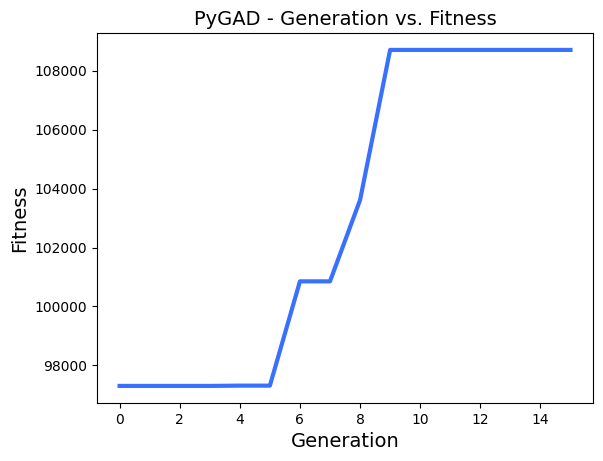

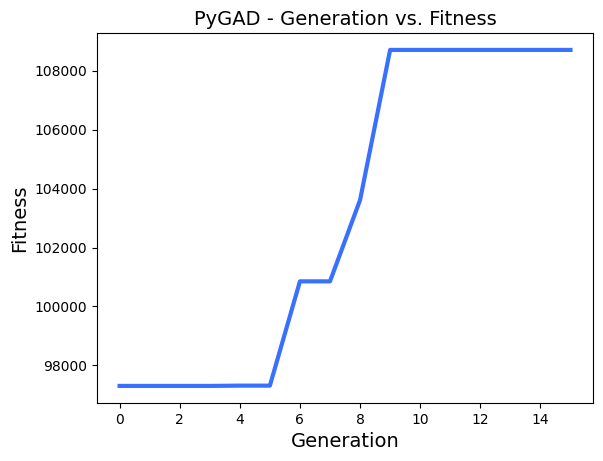

In [459]:
md_fitness_data_arr = numpy.array(md_fitness_measurements_list)
md_fitness_q4 = numpy.quantile(md_fitness_data_arr, 0.95)
md_fit_time_q4_measurements_list = [tuple for tuple in md_fit_time_measurements_list if tuple[0] >= md_fitness_q4]
md_best_fitness_num = len(md_fit_time_q4_measurements_list)
md_best_fitness_avg_time = numpy.mean([tuple[1] for tuple in md_fit_time_q4_measurements_list])
print(md_best_fitness_num, md_best_fitness_avg_time)
ga_instance.plot_fitness()

##### Large input #####


In [460]:
lg_fitness_measurements_list = []
lg_fit_time_measurements_list = []

for i in range(100):
    rand_idx = randint(0, 2)
    input = lg_inputs_list[rand_idx]
    num_genes = len(problem)*moves_per_block
    sol_per_pop = 200
    num_generations = 20
    num_parents_mating = 100
    keep_parents = 10
    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes)
    start = time()
    ga_instance.run()
    stop = time()
    _, solution_fitness, _ = ga_instance.best_solution()
    lg_fitness_measurements_list.append(solution_fitness)
    lg_fit_time_measurements_list.append((solution_fitness, stop - start))


5 4.676278877258301


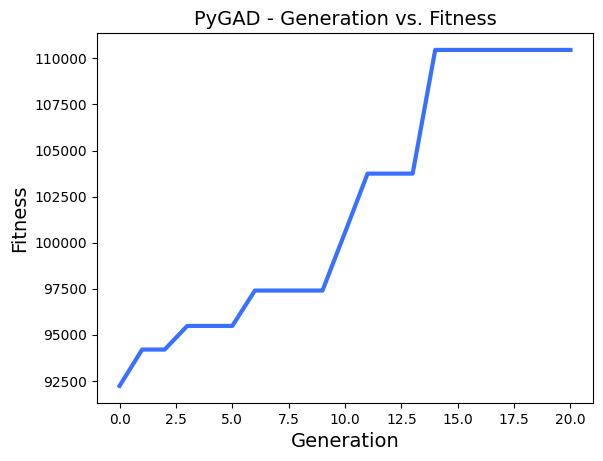

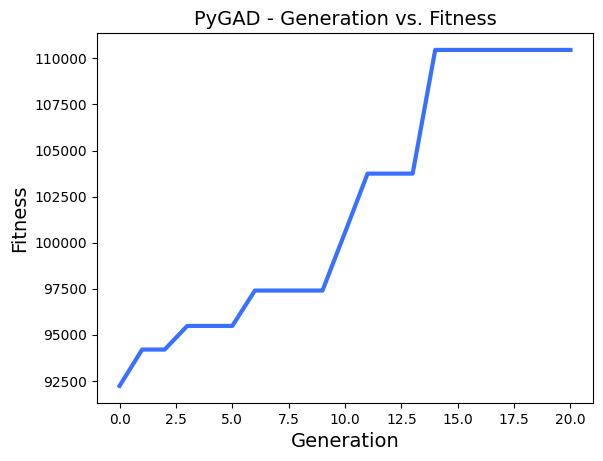

In [461]:
lg_fitness_data_arr = numpy.array(lg_fitness_measurements_list)
lg_fitness_q4 = numpy.quantile(lg_fitness_data_arr, 0.95)
lg_fit_time_q4_measurements_list = [tuple for tuple in lg_fit_time_measurements_list if tuple[0] >= lg_fitness_q4]
lg_best_fitness_num = len(lg_fit_time_q4_measurements_list)
lg_best_fitness_avg_time = numpy.mean([tuple[1] for tuple in lg_fit_time_q4_measurements_list])
print(lg_best_fitness_num, lg_best_fitness_avg_time)
ga_instance.plot_fitness()

#### Prezentacja wyników pomiaru czasu ####

In [462]:
import pandas

measurement_data = pandas.DataFrame([[sm_fitness_q4, md_fitness_q4, lg_fitness_q4], [
                                    sm_best_fitness_avg_time, md_best_fitness_avg_time, lg_best_fitness_avg_time]], columns=["Small input", "Medium input", "Large input"], index=["Q95 fitness", "Average time [s]"])
print(measurement_data)


                    Small input   Medium input    Large input
Q95 fitness       112780.079590  114652.189359  115617.643653
Average time [s]       1.192572       2.625209       4.676279


#### Podsumowanie ####
Ze względu na złożony charakter sposobu oceniania rozwiązań problemu próba manualnego określenia idealnej kombinacji dla danego układu bloków jest praktycznie niemożliwa. W szczególności, wraz ze wzrostem rozmiarów planszy i wielkości zbioru bloków a także ze względu na konieczność przewidywania potencjalnych kolizji bloków w trakcie ruchu. Stąd też efektywność algorytmu genetycznego nie może zostać sprowadzona do oceny przez pojedyncze, pozornie logiczne kryteria(np. wyłączne zliczanie pustych przestrzeni lub różnic wysokości struktury). Jednocześnie dość skuteczną choć niewymierną metodą jest analiza rozwiązania krok po kroku. Istotną kwestią jest też sposób implementacji metody analyse_game(), który miał na celu zachowanie równowagi w nagradzaniu rozwiązań wykorzystujących bonus za zapełnienie pełnego rzędu blokami w czasie gry a takimi, które większość punktów zdobywały poprzez ponadprzeciętnie dobre ułożenie bloków(hipotetycznie kosztem zdobytych pełnych rzędów). Brak tożsamości między punktami zdobytymi w grze a wartością fitness to także próba podejścia do problemu, jakim  jest implementacja algorytmu operującego na skończonych listach w teoretycznie nieskończonej grze.
